## Directory Structure
PLEASE make sure your directory looks like this:
- root_dir
    - pixel-nerf (clone/pull from github)
    - adaptive-volume-rendering (clone/pull from github)
        - 6S980_Project.ipynb
    - scene-representation-networks (clone/pull from github)
    - data
    - checkpoints
    - ......
    
Then set your pwd to root_dir

## Relevant Repos

- PixelNeRF repo: https://github.com/sxyu/pixel-nerf

- SRN repo: https://github.com/vsitzmann/scene-representation-networks

- SRN raymarcher algorithm: https://github.com/vsitzmann/scene-representation-networks/blob/master/custom_layers.py

## Data

- Currently using cars dataset from SRN

## What we did

- Now the pixelnerf with pretrained weights are running!


## Questions
- PixelNeRF currently does: evenly coarse sampling - fine sampling via importance weights - fine sampling around expected depth. With adaptive procedure, what is a fair comparison?

## TODOs
- First attempt: let LSTM interact with the features, do 10 steps, then directly output a color
- Second attempt: sample points around the final location and do volume integral

In [2]:
root_dir = "/Users/yankesong/Documents/YankeSong/Harvard Textbook/MIT 6.S980/Project/"       # This is the only thing you need to change.
%cd "/Users/yankesong/Documents/YankeSong/Harvard Textbook/MIT 6.S980/Project/"

# root_dir = "/Users/jameszli/desktop/MIT/6.S980/"       # This is the only thing you need to change.
# %cd "/Users/jameszli/desktop/MIT/6.S980/"

# # Install everything
# %pip install -r adaptive-volume-rendering/requirements.txt

# Import everything
import sys

sys.path.insert(0, f"{root_dir}/scene-representation-networks/")
sys.path.insert(0, f"{root_dir}/pixel-nerf/src/")
sys.path.insert(0, f"{root_dir}/adaptive-volume-rendering/")

from model import make_model, loss
from dataset import *
from models import *
from renderers import *
from trains import *
from utils import *


print(f"Installed Torch version: {torch.__version__}")

if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

print(device)

/Users/yankesong/Documents/YankeSong/Harvard Textbook/MIT 6.S980/Project


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Installed Torch version: 1.13.0
cpu


## Setup & Load Test Data

In [3]:
# Download data and weights

# Make a new directory
!mkdir data
!mkdir checkpoints

# Download Test Dataset
if not os.path.exists(f"{root_dir}data/cars_train.hdf5"):
    # Download SRNs-cars dataset
    gdown.download("https://drive.google.com/uc?id={}".format("1SBjlsizq0sFNkCZxMQh-pNRi0HyFozKb"),f"{root_dir}data/cars_train.hdf5")


## Download pretrained weights from PixelNeRF
if not os.path.exists(f"{root_dir}checkpoints/pixel_nerf_weights.zip"):
  gdown.download("https://drive.google.com/uc?id={}".format("1UO_rL201guN6euoWkCOn-XpqR2e8o6ju"),f"{root_dir}checkpoints/pixel_nerf_weights.zip")
  !unzip checkpoints/pixel_nerf_weights.zip -d checkpoints/

mkdir: data: File exists
mkdir: checkpoints: File exists


In [4]:
# # View test image
# sl = 128
# dataset = SRNsCars(root_dir,img_sidelength=sl)
# mi = next(iter(dataset))

# rgb = mi['images'].reshape(sl, sl, 3)

# plt.imshow(rgb)
# plt.show()

# print("Cam2world ", mi['cam2world'])
# print("Intrinsics ", mi['intrinsics'])
# print("Pixel coords", mi['x_pix'], mi['x_pix'].max())
# print("Scene idx", mi['idx'])


# # Below are for pixelnerf convention
# key = "4e384de22a760ef72e877e82c90c24d"


# for i in range(250):
#     observation_idx = list(str(100000 + i))
#     observation_idx[0] = '0'
#     observation_idx = "".join(observation_idx)
#     pose_path = f"{root_dir}data/cars_train/{key}/pose/{observation_idx}.txt"
#     pose = torch.from_numpy(
#                 np.loadtxt(pose_path, dtype=np.float32).reshape(4, 4)
#             )
#     #print(abs(pose[0,0] - mi['cam2world'][0,0]))
#     if abs(pose[0,0] - mi['cam2world'][0,0]) < 2e-2:
#         print(f'found it! observation number {observation_idx}')
#         print(pose)

#         rgb_path = f"{root_dir}data/cars_train/{key}/rgb/{observation_idx}.png"
#         img = imageio.imread(rgb_path)[..., :3]
#         to_tensor = transforms.ToTensor()
#         img_tensor = to_tensor(img)
#         plt.imshow(img)


In [5]:
# Checking axis alignment
# sl = 4
# print(get_opencv_pixel_coordinates(sl,sl))
# Y, X = torch.meshgrid(
#         torch.arange(sl, dtype=torch.float32),
#         torch.arange(sl, dtype=torch.float32),
#     )
# print(torch.stack((X, Y)))

## Renderer

Loading PixlNeRF models

- The volume renderer is in src/nerf.py
- Can easily wrap a net with a renderer using _RenderWrapper function
- The current volume renderer samples points in the following way:
  - Sample 64 coarse points (uniform sample)
  - Sample 16 fine points (importance sample, still need to check how)
  - Compute an expected depth, then sample 16 random normal points with sd=0.01 around that depth.

In [6]:
# ############## Original Volume renderer
# # Create a custom conf
# from pyhocon import ConfigFactory
# conf = ConfigFactory.parse_file(f"adaptive-volume-rendering/conf/default_mv.conf")

# # Create a pixelnerf net
# net = make_new_model(conf["model"]).to(device=device)
# net.stop_encoder_grad = True

# # Load pretrianed weights
# model_path = f"{root_dir}checkpoints/srn_car/pixel_nerf_latest"
# net.load_weights(model_path)

# # Combine with volumerenderer
# renderer = VolumeRenderer.from_conf(conf["normal_renderer"]).to(
#     device=device
# )

# rf_and_renderer = RadFieldAndRenderer(net, renderer).to(device=device)

# # Test dataset
# sl = 32
# train_dataset = SceneClassDataset(root_dir=f"{root_dir}data/cars_train",
#                                              max_num_instances=1,
#                                              max_observations_per_instance=50,
#                                              img_sidelength=sl,
#                                              specific_observation_idcs=None,
#                                              samples_per_instance=4)



# train_dataloader = DataLoader(train_dataset,
#                                       batch_size=1,
#                                       shuffle=True,
#                                       drop_last=True,
#                                       collate_fn=train_dataset.collate_fn
#                                       )

# # Configurations
# optim = torch.optim.Adam(lr=1e-3, params=rf_and_renderer.parameters())

# try:
#     _ = fit(net,
#         rf_and_renderer, 
#         iter(train_dataloader), 
#         loss_fn=mse_loss, 
#         resolution=(sl, sl, 3), 
#         plotting_function=plot_output_ground_truth, 
#         optimizer=optim, 
#         total_steps=500,
#         steps_til_summary=10
#         )
# except Exception:
#     print(traceback.format_exc())



### PixelNeRF + Raymarcher

Using torchvision resnet34 encoder


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Load /Users/yankesong/Documents/YankeSong/Harvard Textbook/MIT 6.S980/Project/checkpoints/srn_car/pixel_nerf_latest


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3191.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Final step: Min depth -4.492886, max depth -0.062214
Step 0: loss = 89950.10938


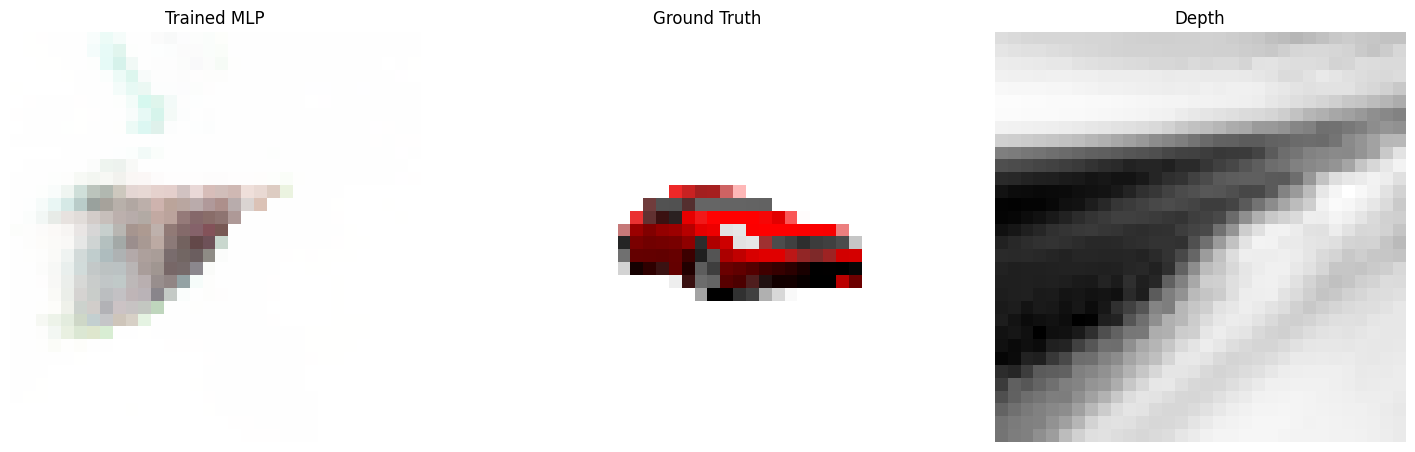

Final step: Min depth -5.052033, max depth 0.794432
Final step: Min depth -3.011481, max depth 1.149677
Final step: Min depth -2.833978, max depth 2.218028
Final step: Min depth -2.197037, max depth 2.558607
Final step: Min depth -1.768224, max depth 2.931800
Final step: Min depth -0.823563, max depth 3.179689
Final step: Min depth -0.992697, max depth 3.557614
Final step: Min depth -1.039352, max depth 3.224684
Final step: Min depth 0.295817, max depth 4.026834
Final step: Min depth 0.270101, max depth 4.246308
Final step: Min depth 0.133090, max depth 4.034759
Final step: Min depth 0.531730, max depth 3.792705
Final step: Min depth 1.351381, max depth 4.548762
Final step: Min depth 1.320833, max depth 4.179031
Final step: Min depth 0.430339, max depth 4.106458
Final step: Min depth 0.964713, max depth 4.013210
Final step: Min depth 0.689850, max depth 4.299637
Final step: Min depth 1.113076, max depth 4.015747
Final step: Min depth 0.716195, max depth 3.002878
Final step: Min depth 0

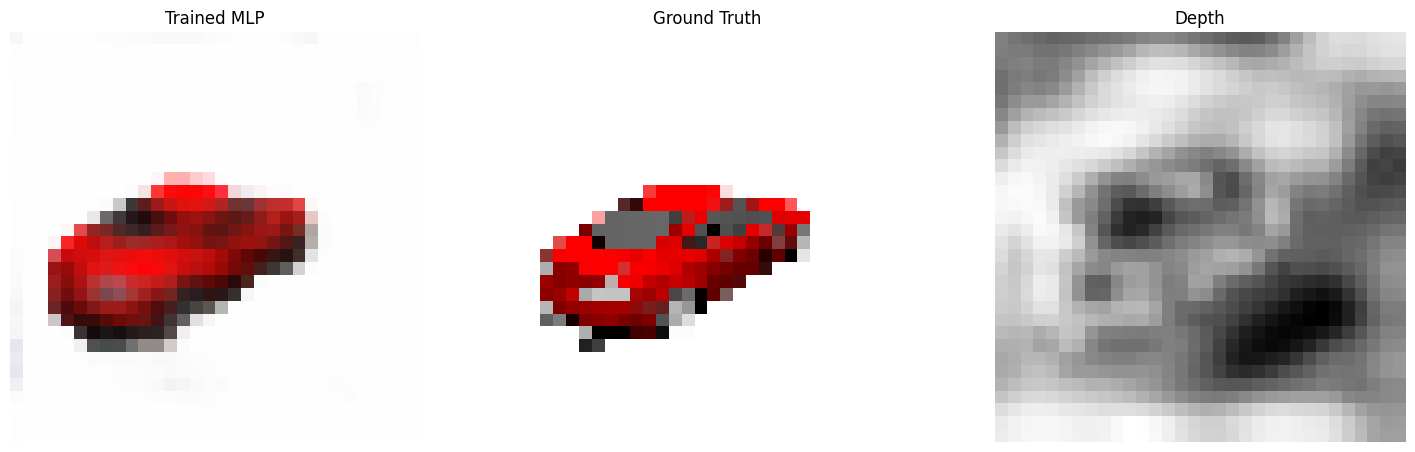

Final step: Min depth 0.454316, max depth 2.421188
Final step: Min depth 0.355833, max depth 2.462070
Final step: Min depth 0.092952, max depth 2.120536
Final step: Min depth 0.255393, max depth 2.487154
Final step: Min depth -0.078496, max depth 1.985050
Final step: Min depth 0.324302, max depth 2.289427
Final step: Min depth 0.270993, max depth 2.324224
Final step: Min depth 0.359493, max depth 2.458684
Final step: Min depth 0.056302, max depth 2.097601
Final step: Min depth 0.183002, max depth 2.271221
Final step: Min depth 0.540784, max depth 2.116721
Final step: Min depth 0.043353, max depth 2.515433
Final step: Min depth 0.361005, max depth 2.473543
Final step: Min depth -0.068776, max depth 1.984385
Final step: Min depth 0.559584, max depth 2.352172
Final step: Min depth 0.118575, max depth 2.139441
Final step: Min depth 0.472767, max depth 2.230996
Final step: Min depth 0.168685, max depth 1.760483
Final step: Min depth 0.083420, max depth 2.020448
Final step: Min depth 0.49811

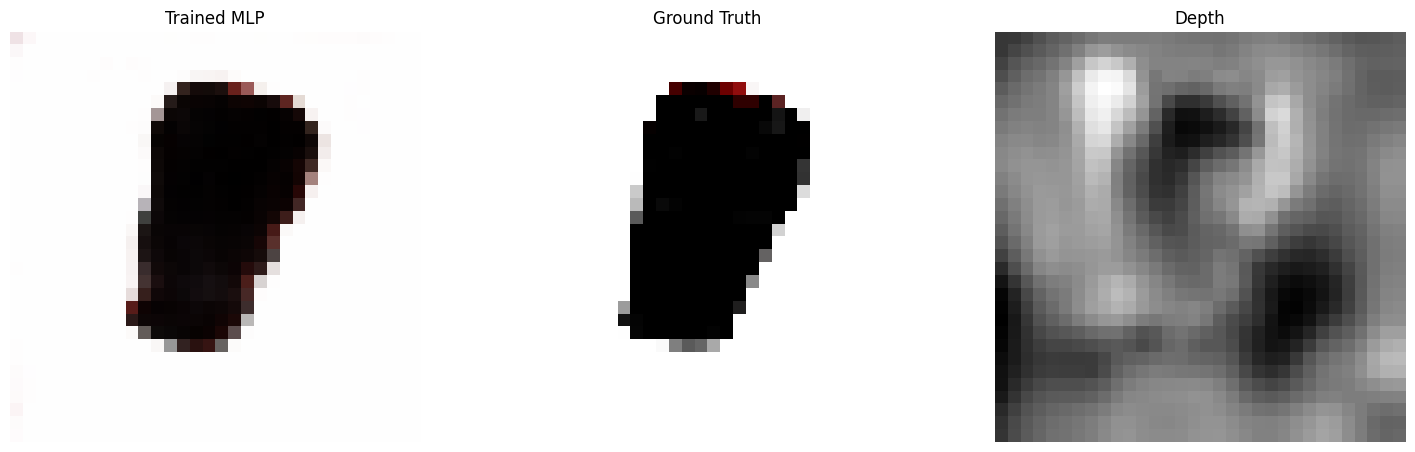

Final step: Min depth 0.545048, max depth 2.221318
Final step: Min depth 0.166075, max depth 2.268455
Final step: Min depth -0.009002, max depth 2.002562
Final step: Min depth 0.420480, max depth 2.239863
Final step: Min depth 0.468090, max depth 2.206158
Final step: Min depth 0.588123, max depth 1.980934
Final step: Min depth 0.234113, max depth 2.567703
Final step: Min depth 0.142634, max depth 2.089602
Final step: Min depth -0.290379, max depth 1.990694
Final step: Min depth 0.175907, max depth 2.043712
Final step: Min depth 0.450266, max depth 2.410661
Final step: Min depth 0.246315, max depth 2.186760
Final step: Min depth 0.024512, max depth 1.899277
Final step: Min depth 0.137196, max depth 2.433684
Final step: Min depth 0.354108, max depth 2.020954
Final step: Min depth 0.346184, max depth 1.947941
Final step: Min depth -0.013551, max depth 1.974878
Final step: Min depth 0.573058, max depth 2.487732
Final step: Min depth 0.401401, max depth 2.186912
Final step: Min depth 0.5288

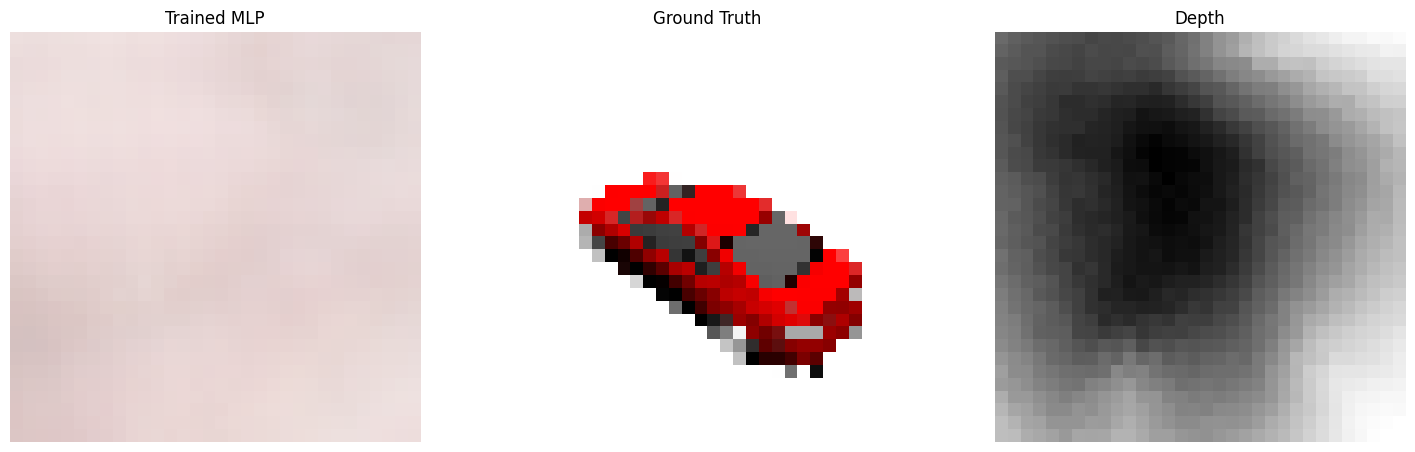

Final step: Min depth -0.229286, max depth 2.079044
Final step: Min depth 0.449375, max depth 2.302640
Final step: Min depth 0.597366, max depth 2.404542
Final step: Min depth 0.452333, max depth 1.952806
Final step: Min depth 0.467770, max depth 1.852272
Final step: Min depth 0.535318, max depth 2.118705
Final step: Min depth 0.394442, max depth 1.982228
Final step: Min depth 0.423758, max depth 2.167593
Final step: Min depth 0.468554, max depth 2.313649
Final step: Min depth 0.304981, max depth 1.793792
Final step: Min depth 0.116430, max depth 2.011682
Final step: Min depth 0.519765, max depth 2.370314
Final step: Min depth 0.445814, max depth 2.139570
Final step: Min depth 0.004956, max depth 2.004618
Final step: Min depth -0.014805, max depth 2.029985
Final step: Min depth 0.002241, max depth 2.007361
Final step: Min depth 0.279185, max depth 1.632586
Final step: Min depth 0.460048, max depth 2.156246
Final step: Min depth 0.442081, max depth 2.324187
Final step: Min depth 0.57596

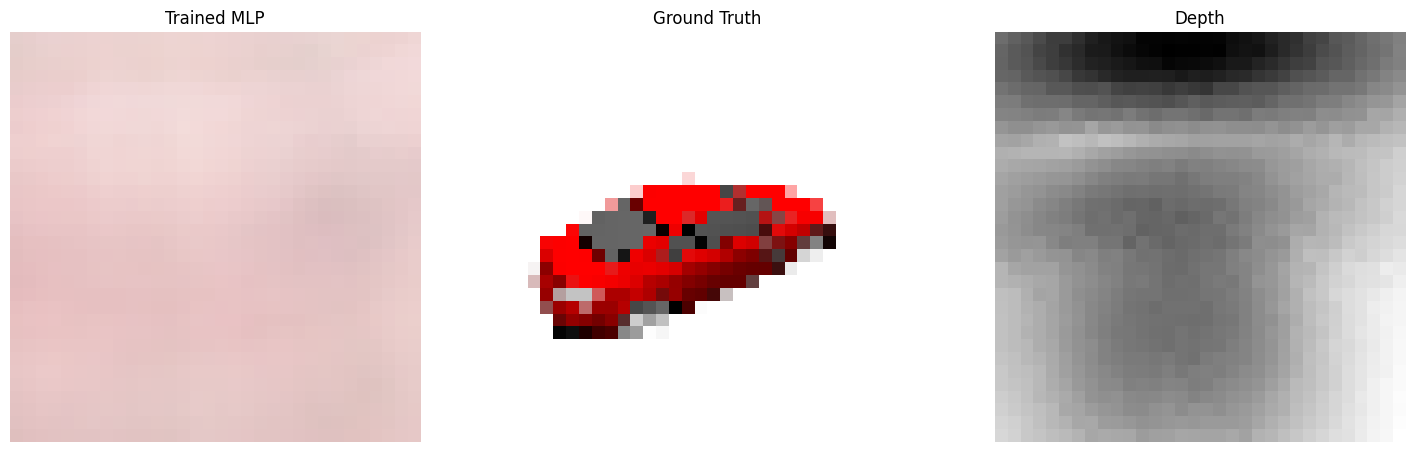

Final step: Min depth 0.512684, max depth 2.048479
Final step: Min depth 0.464220, max depth 2.046298
Final step: Min depth 0.583080, max depth 2.003860
Final step: Min depth 0.384532, max depth 1.900149
Final step: Min depth 0.402088, max depth 1.997366
Final step: Min depth 0.242595, max depth 1.928001
Final step: Min depth 0.496524, max depth 1.784071
Final step: Min depth 0.575335, max depth 2.092788
Final step: Min depth 0.152298, max depth 1.906763
Final step: Min depth 0.181064, max depth 1.716167
Final step: Min depth 0.336347, max depth 2.305712
Final step: Min depth 0.542162, max depth 2.171562
Final step: Min depth 0.563622, max depth 2.248279
Final step: Min depth 0.539932, max depth 1.880681
Final step: Min depth 0.250198, max depth 1.931059
Final step: Min depth 0.655276, max depth 2.089342
Final step: Min depth 0.264778, max depth 1.906836
Final step: Min depth 0.167726, max depth 1.592794
Final step: Min depth 0.284692, max depth 1.744304
Final step: Min depth 0.265961,

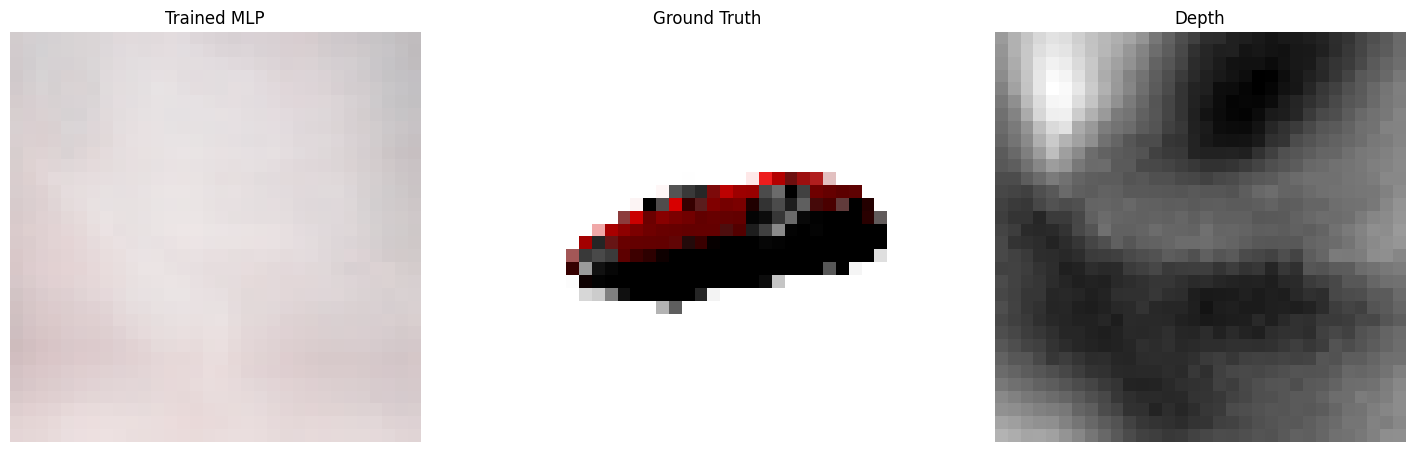

Final step: Min depth 0.050102, max depth 1.896688
Final step: Min depth 0.033736, max depth 1.943204
Final step: Min depth 0.457430, max depth 2.180347
Final step: Min depth 0.321752, max depth 1.747848
Final step: Min depth 0.614914, max depth 1.997672
Final step: Min depth 0.278279, max depth 2.263848
Final step: Min depth 0.512838, max depth 2.023697
Final step: Min depth 0.629048, max depth 1.986139
Final step: Min depth 0.199628, max depth 1.604620
Final step: Min depth -0.117541, max depth 1.869862
Final step: Min depth 0.357000, max depth 1.974564
Final step: Min depth 0.354103, max depth 2.045683
Final step: Min depth 0.368398, max depth 2.168540
Final step: Min depth 0.486928, max depth 1.965368
Final step: Min depth 0.336982, max depth 1.915029
Final step: Min depth 0.597068, max depth 2.084260
Final step: Min depth 0.419756, max depth 1.732282
Final step: Min depth 0.649446, max depth 2.060509
Final step: Min depth 0.373425, max depth 1.940925
Final step: Min depth 0.363343

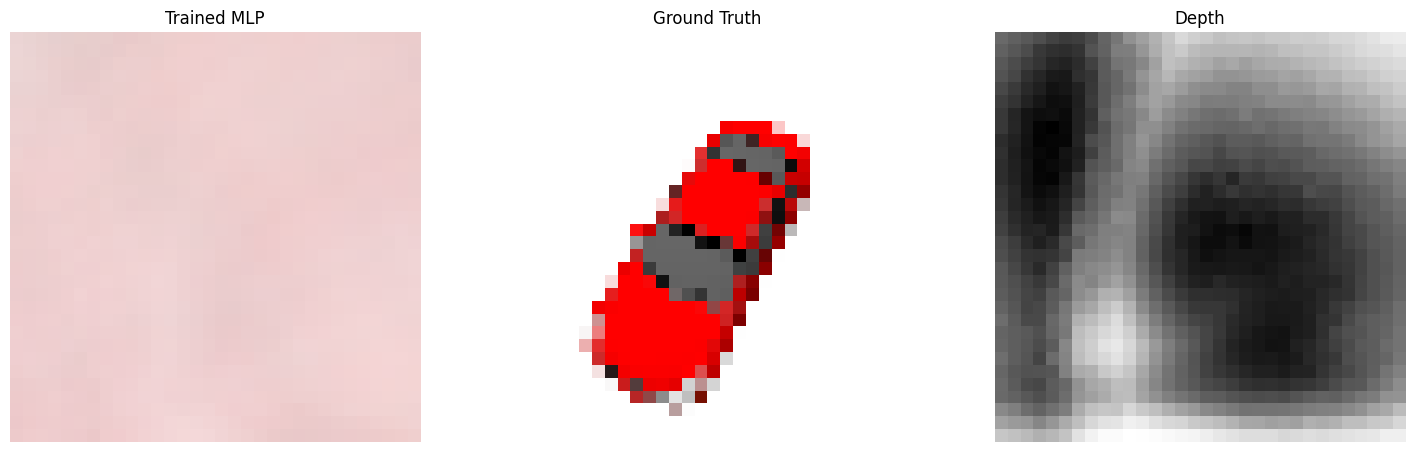

Final step: Min depth 0.519384, max depth 1.962387
Final step: Min depth 0.363391, max depth 1.969001
Final step: Min depth 0.290151, max depth 2.205615
Final step: Min depth 0.528426, max depth 1.950331
Final step: Min depth 0.431814, max depth 2.037295
Final step: Min depth 0.361196, max depth 2.222559
Final step: Min depth 0.457774, max depth 2.152113
Final step: Min depth 0.516637, max depth 1.969349
Final step: Min depth 0.351086, max depth 2.202356
Final step: Min depth 0.446315, max depth 1.853618
Final step: Min depth 0.364487, max depth 1.891577
Final step: Min depth 0.536339, max depth 1.982785
Final step: Min depth 0.542399, max depth 1.877135
Final step: Min depth 0.256431, max depth 2.027768
Final step: Min depth 0.602096, max depth 1.943367
Final step: Min depth 0.529338, max depth 1.852154
Final step: Min depth 0.259105, max depth 1.988272
Final step: Min depth 0.354550, max depth 1.563231
Final step: Min depth 0.195362, max depth 1.840384
Final step: Min depth 0.504834,

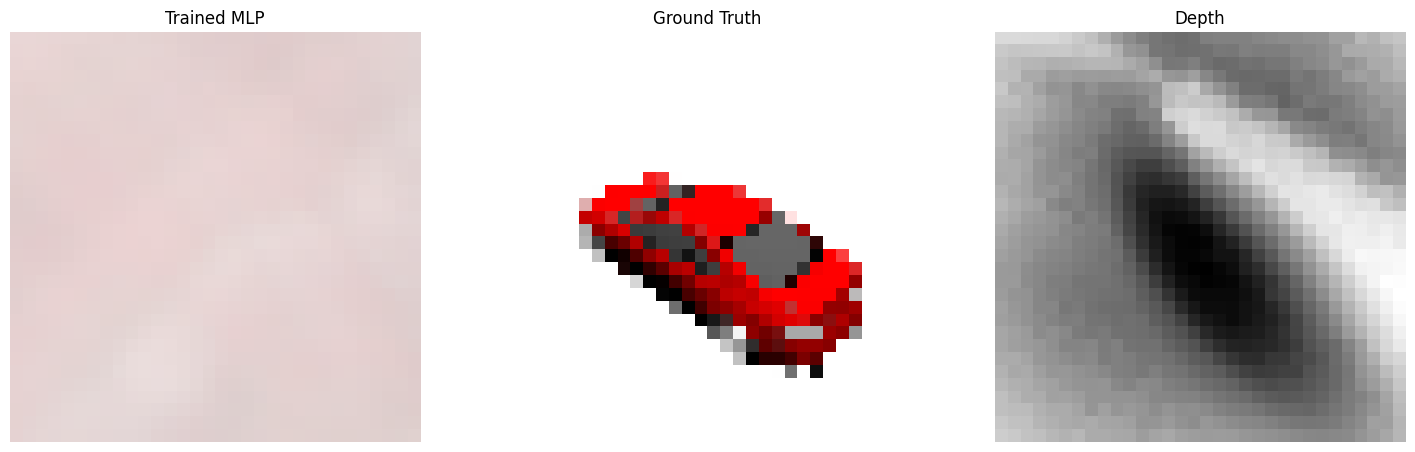

Final step: Min depth 0.454734, max depth 2.181089
Final step: Min depth 0.362383, max depth 2.094643
Final step: Min depth 0.482047, max depth 1.758133
Final step: Min depth 0.367352, max depth 1.579124
Final step: Min depth 0.316417, max depth 2.125037
Final step: Min depth -0.050067, max depth 1.924658
Final step: Min depth 0.247902, max depth 1.934893
Final step: Min depth 0.322972, max depth 2.118152
Final step: Min depth 0.461406, max depth 2.186209
Final step: Min depth 0.377283, max depth 1.802974
Final step: Min depth 0.519209, max depth 2.055749
Final step: Min depth 0.356420, max depth 1.948390
Final step: Min depth 0.486946, max depth 2.123348
Final step: Min depth 0.388239, max depth 1.925853
Final step: Min depth -0.007177, max depth 1.940679
Final step: Min depth 0.570149, max depth 1.908118
Final step: Min depth 0.265326, max depth 1.922964
Final step: Min depth 0.636663, max depth 1.982566
Final step: Min depth 0.538989, max depth 1.937132
Final step: Min depth 0.40522

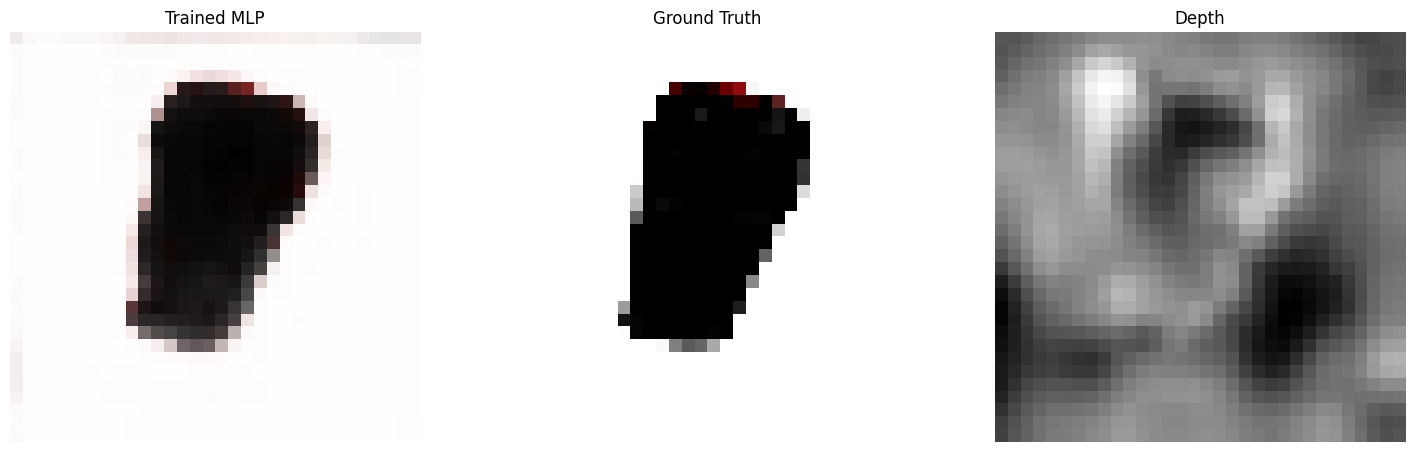

Final step: Min depth 0.468328, max depth 1.902327
Final step: Min depth 0.420225, max depth 1.820110
Final step: Min depth 0.148633, max depth 2.034095
Final step: Min depth 0.608015, max depth 2.250953
Final step: Min depth 0.372456, max depth 2.035181
Final step: Min depth 0.495199, max depth 2.145226
Final step: Min depth 0.375805, max depth 2.245031
Final step: Min depth 0.442721, max depth 1.920162
Final step: Min depth 0.697626, max depth 1.999764
Final step: Min depth 0.354223, max depth 1.998184
Final step: Min depth 0.467672, max depth 2.032009
Final step: Min depth 0.561361, max depth 1.855918
Final step: Min depth 0.461894, max depth 2.032595
Final step: Min depth 0.526792, max depth 1.894773
Final step: Min depth 0.403785, max depth 2.196745
Final step: Min depth 0.597247, max depth 1.957479
Final step: Min depth 0.420252, max depth 1.704057
Final step: Min depth 0.612795, max depth 2.199642
Final step: Min depth 0.404596, max depth 2.182097
Final step: Min depth 0.627085,

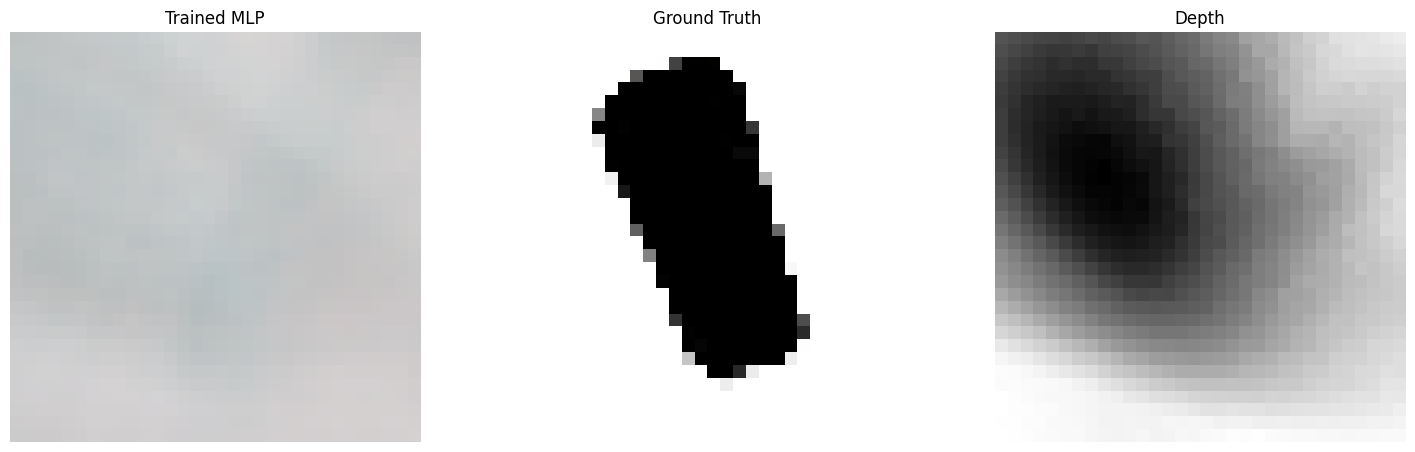

Final step: Min depth 0.378813, max depth 1.986802
Final step: Min depth 0.635795, max depth 2.000450
Final step: Min depth 0.379607, max depth 2.223730
Final step: Min depth 0.073720, max depth 1.875426
Final step: Min depth 0.436299, max depth 1.875527
Final step: Min depth 0.533827, max depth 1.873766
Final step: Min depth 0.392873, max depth 2.022458
Final step: Min depth 0.470372, max depth 2.193997
Final step: Min depth 0.431546, max depth 1.947796
Final step: Min depth 0.561725, max depth 2.251817
Final step: Min depth 0.300059, max depth 1.588972
Final step: Min depth 0.481439, max depth 2.095343
Final step: Min depth 0.573405, max depth 1.852648
Final step: Min depth 0.078403, max depth 1.865124
Final step: Min depth 0.549802, max depth 2.240217
Final step: Min depth 0.467643, max depth 2.188005
Final step: Min depth 0.700467, max depth 1.962554
Final step: Min depth 0.462301, max depth 1.868066
Final step: Min depth 0.698267, max depth 2.010325
Final step: Min depth 0.478630,

In [7]:
# Create a custom conf
from pyhocon import ConfigFactory
conf = ConfigFactory.parse_file(f"{root_dir}adaptive-volume-rendering/conf/default_mv.conf")

# Create a pixelnerf net
net = make_new_model(conf["model"]).to(device=device)
net.stop_encoder_grad = True

# Load pretrianed weights
model_path = f"{root_dir}checkpoints/srn_car/pixel_nerf_latest"
net.load_weights(model_path)

# Combine with volumerenderer
renderer = Raymarcher.from_conf(conf["raymarcher"]).to(
    device=device
)

rf_and_renderer = RadFieldAndRenderer(net, renderer).to(device=device)

######## TODO
# Test dataset
sl = 32
train_dataset = SceneClassDataset(root_dir=f"{root_dir}data/cars_train",
                                             max_num_instances=1,
                                             max_observations_per_instance=50,
                                             img_sidelength=sl,
                                             specific_observation_idcs=None,
                                             samples_per_instance=2)


train_dataloader = DataLoader(train_dataset,
                                      batch_size=1,
                                      shuffle=True,
                                      drop_last=True,
                                      collate_fn=train_dataset.collate_fn
                                      )

# Configurations
optim = torch.optim.Adam(lr=1e-3, params=rf_and_renderer.parameters())

try:
    _ = fit(net,
        rf_and_renderer, 
        train_dataloader, 
        loss_fn=mse_regularization_loss, 
        resolution=(sl, sl, 3), 
        plotting_function=plot_output_ground_truth, 
        optimizer=optim, 
        total_steps=1000,
        steps_til_summary=100
        )
except Exception:
    print(traceback.format_exc())

### PixelNeRF + Adaptive Volume Renderer

Using torchvision resnet34 encoder
Load /Users/yankesong/Documents/YankeSong/Harvard Textbook/MIT 6.S980/Project/checkpoints/srn_car/pixel_nerf_latest


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 0: loss = 755569753359122432.00000
same view dir as src


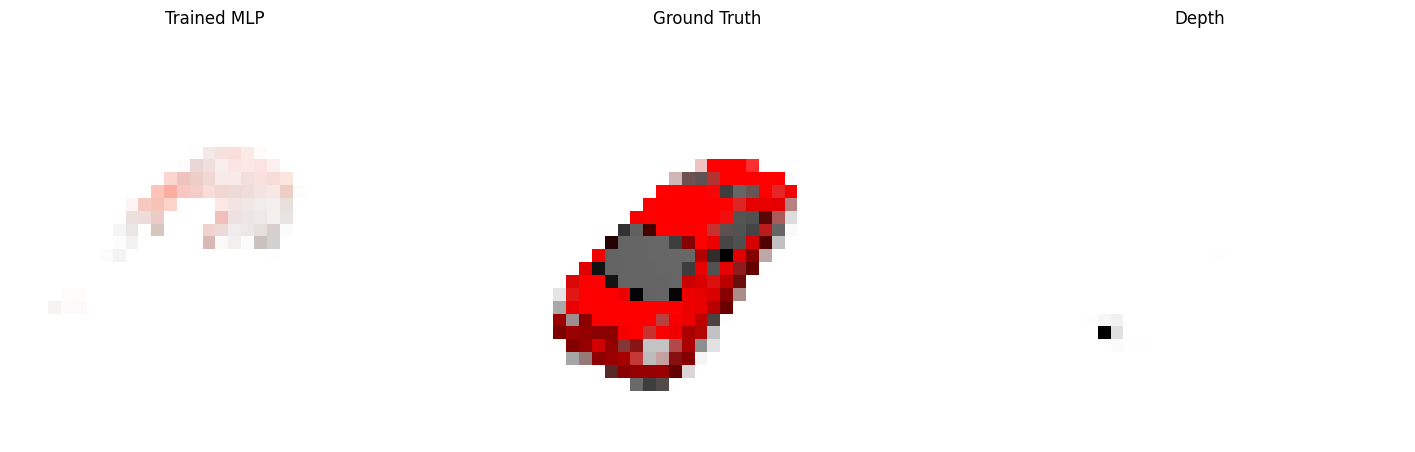

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 10: loss = 123337728589824.00000
same view dir as src


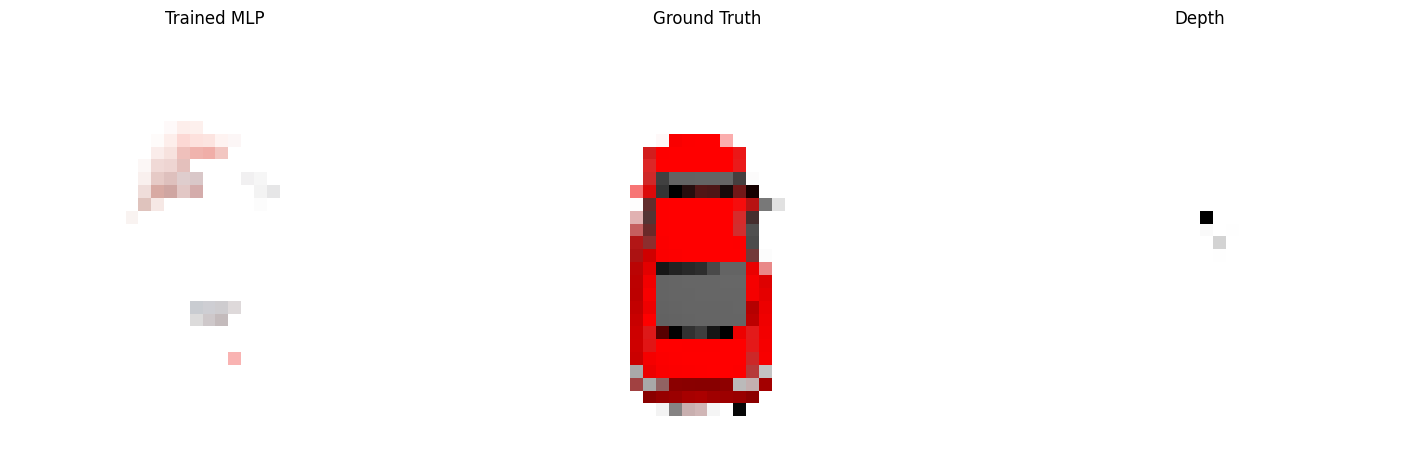

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 20: loss = 30253474906112.00000


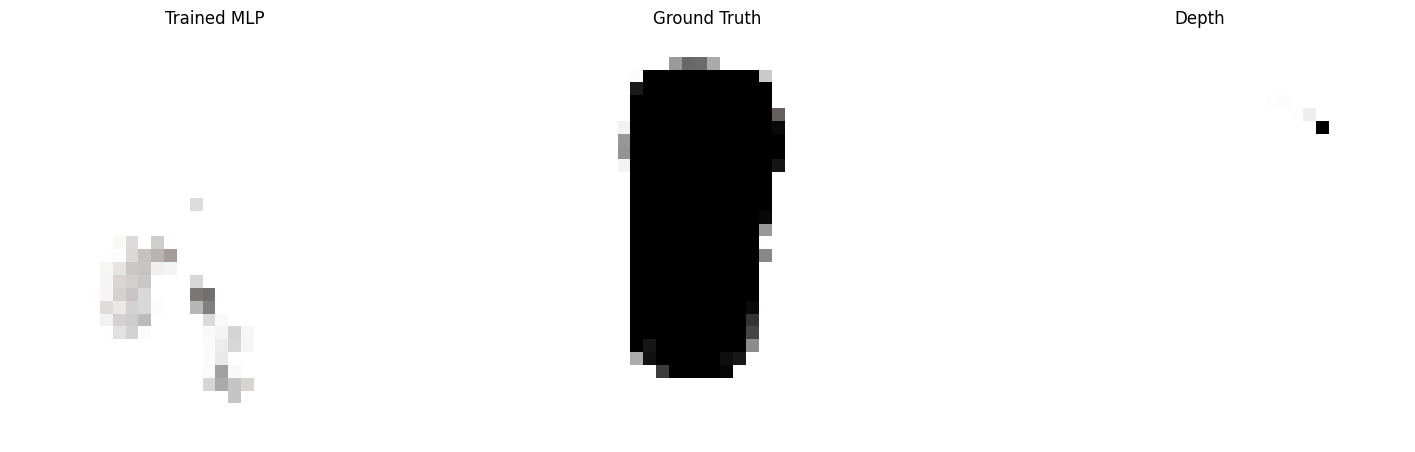

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 30: loss = 1171471181512487826914017280.00000


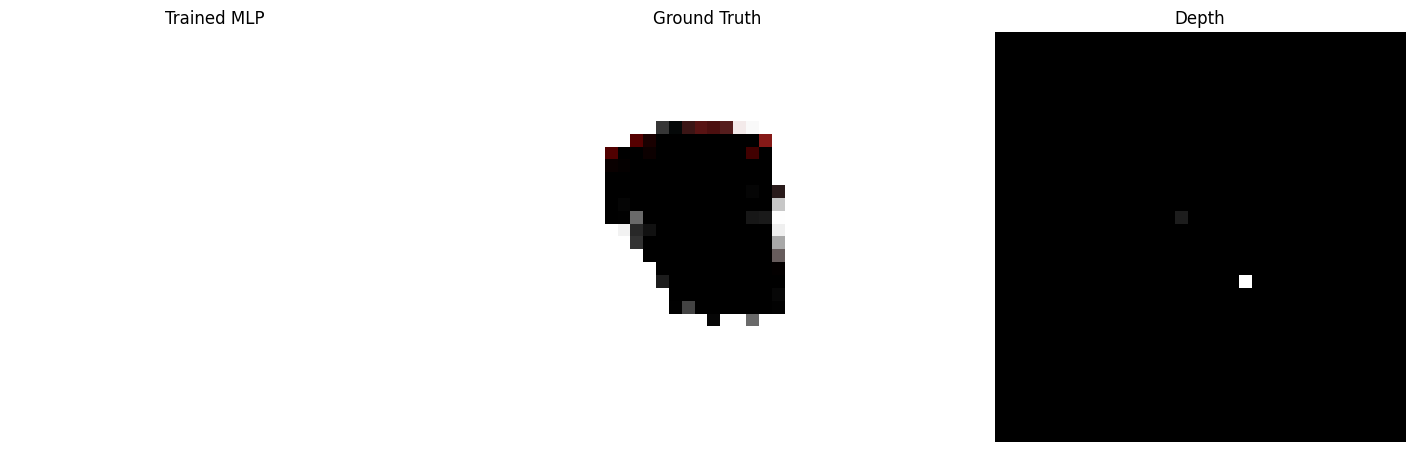

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 40: loss = 4628791.00000
same view dir as src


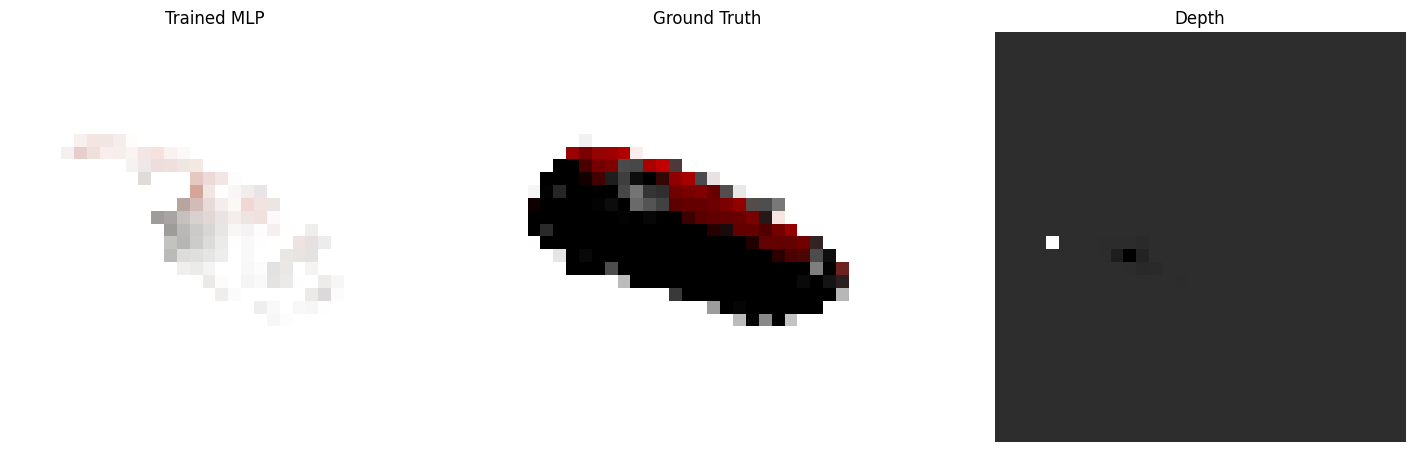

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 50: loss = 14404.33594
same view dir as src


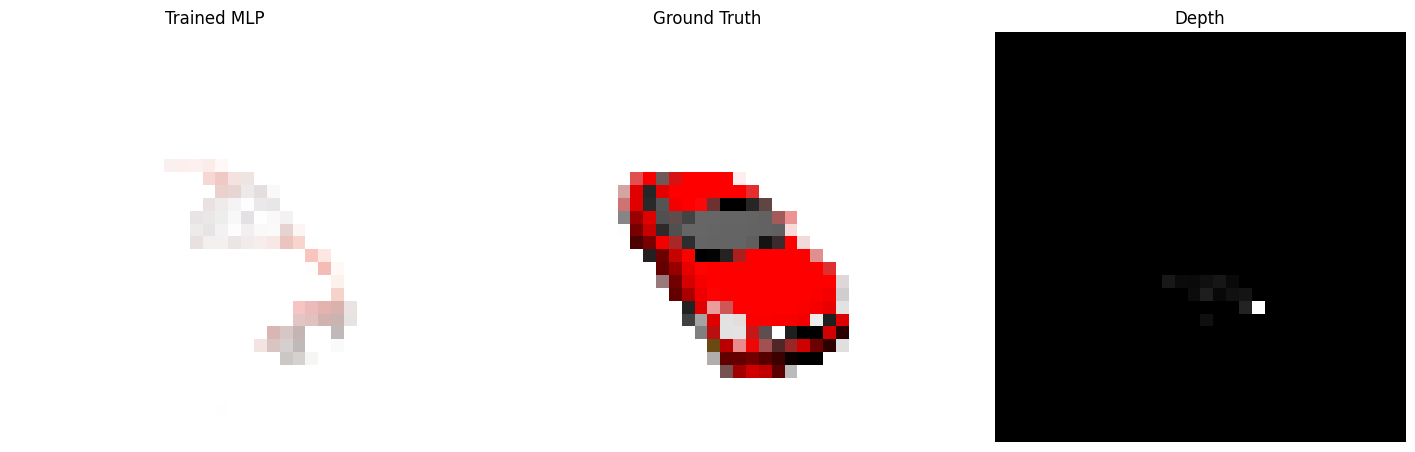

Step 60: loss = 0.11128


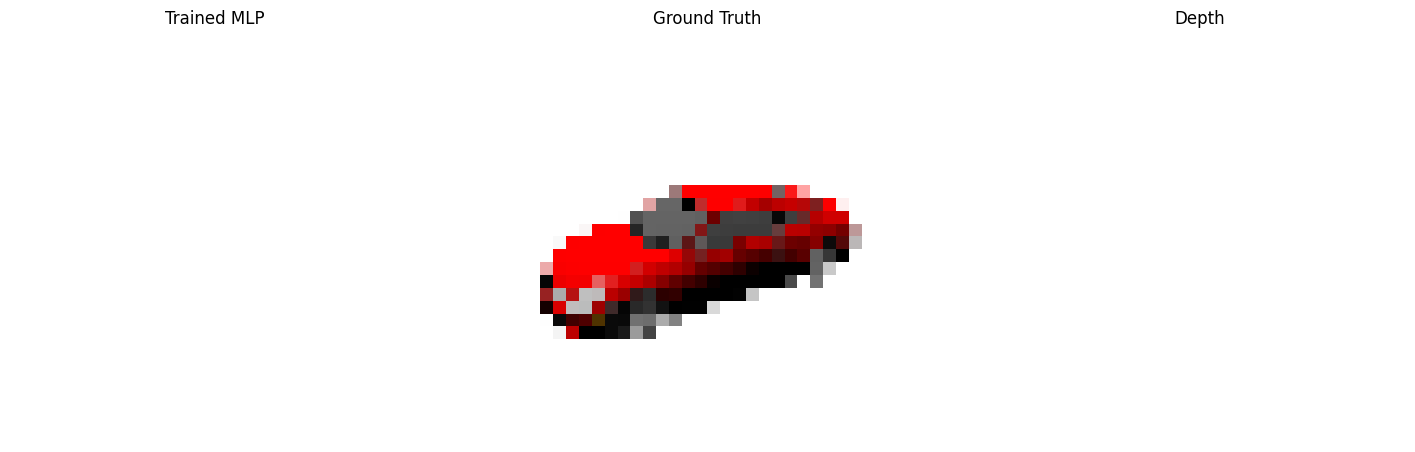

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 70: loss = 7.04226
same view dir as src


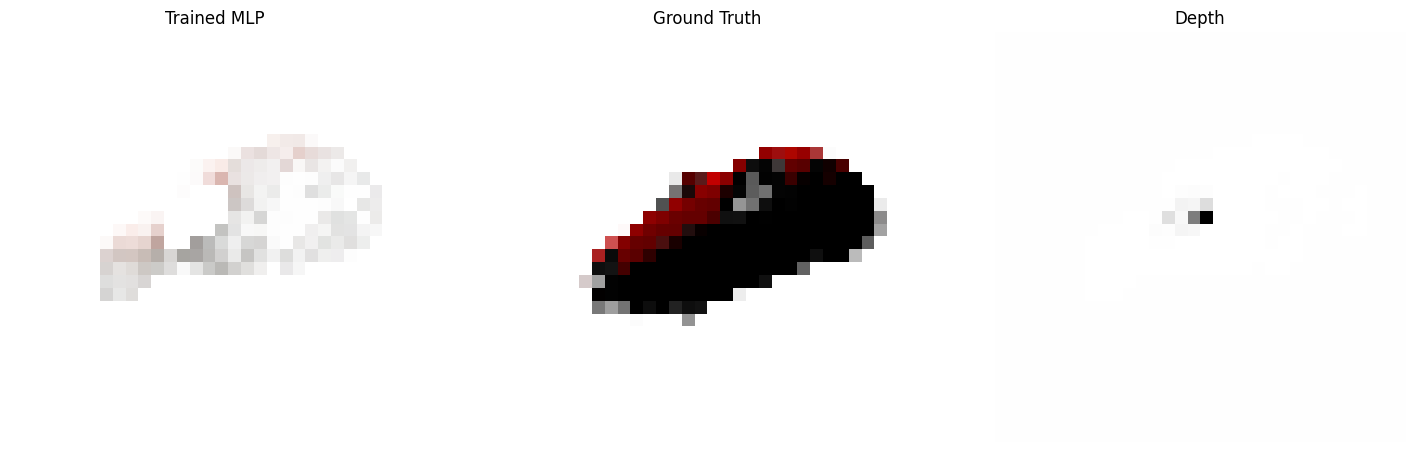

Step 80: loss = 0.14059


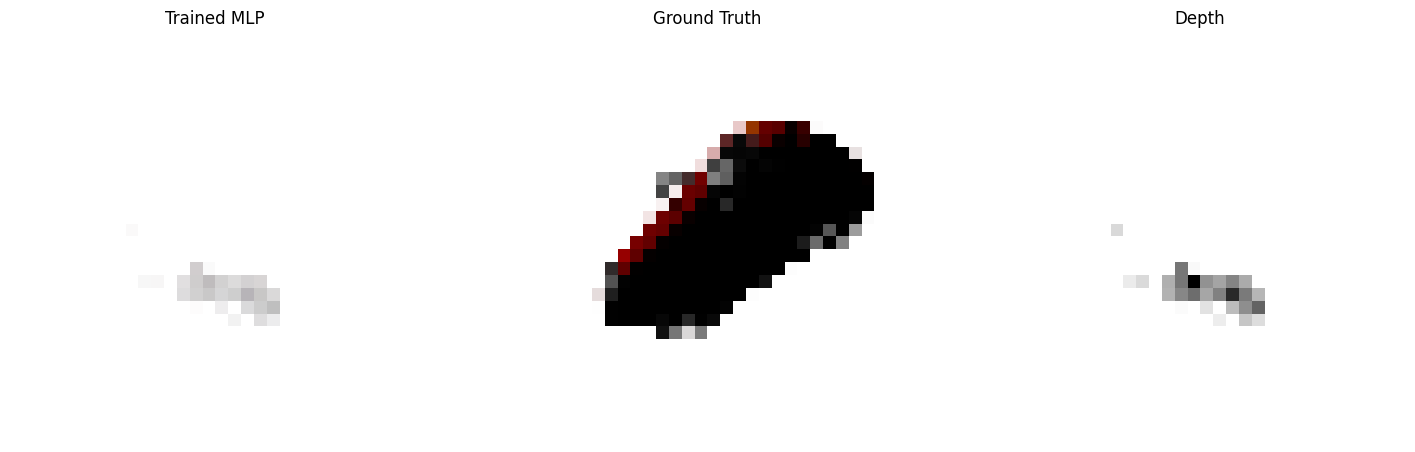

Step 90: loss = 0.09390


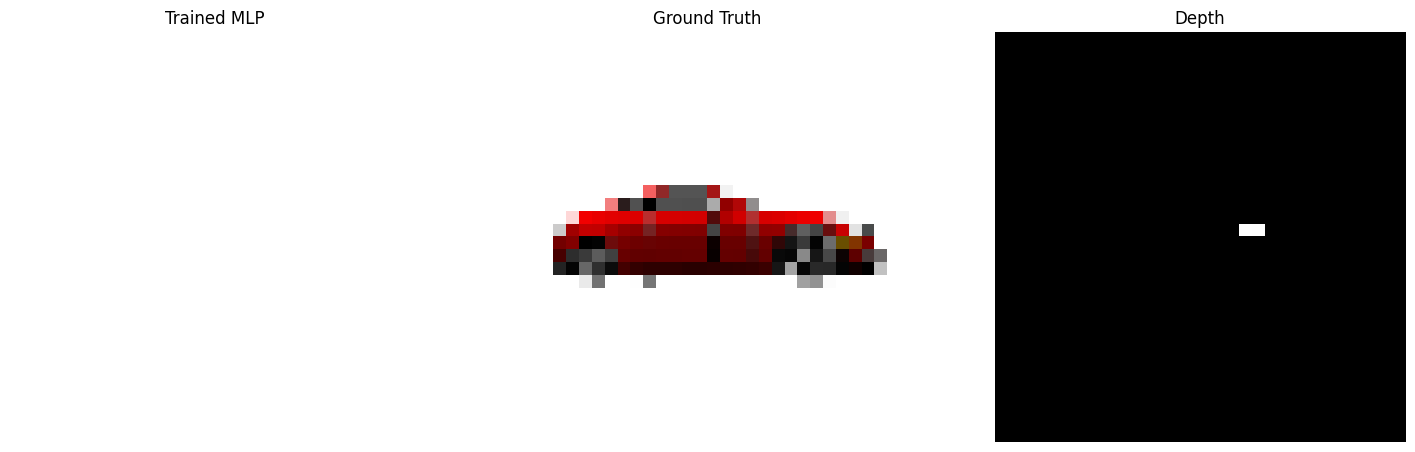

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 100: loss = 8868901888.00000
same view dir as src


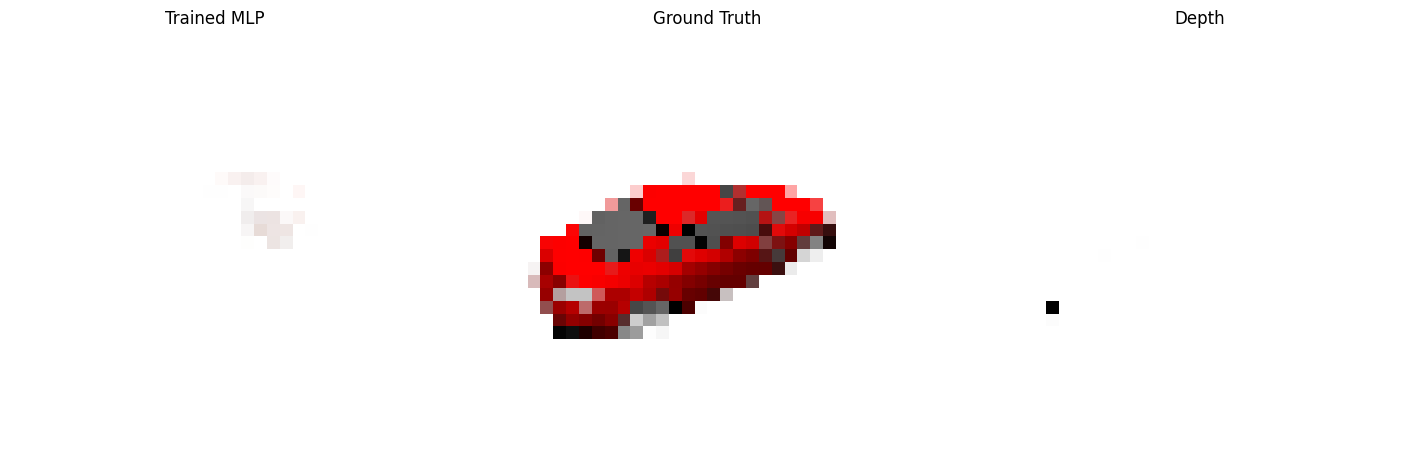

Step 110: loss = 0.16600


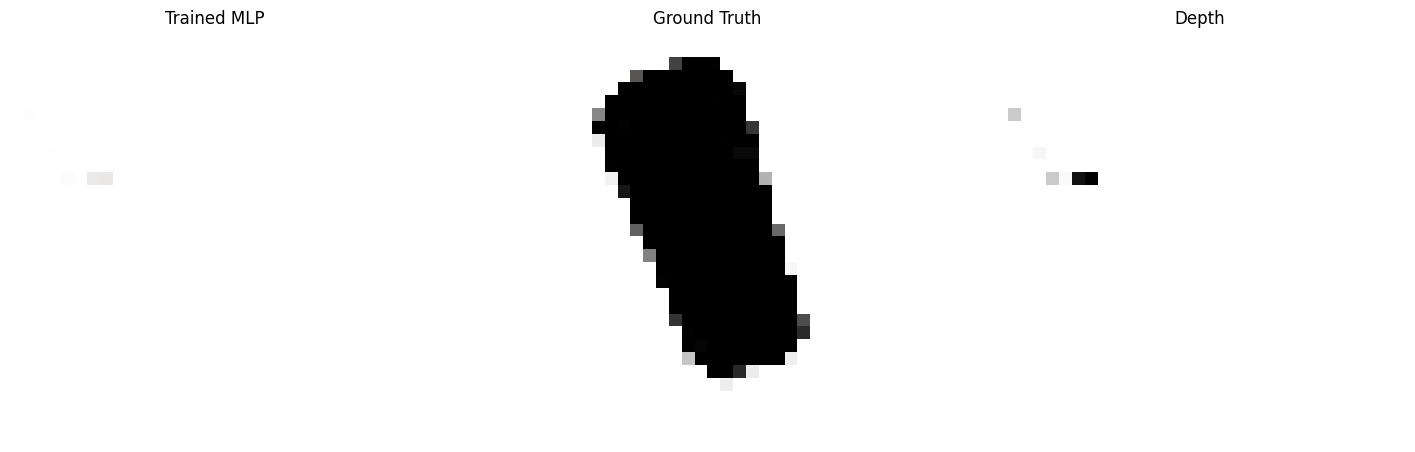

Step 120: loss = 0.11952


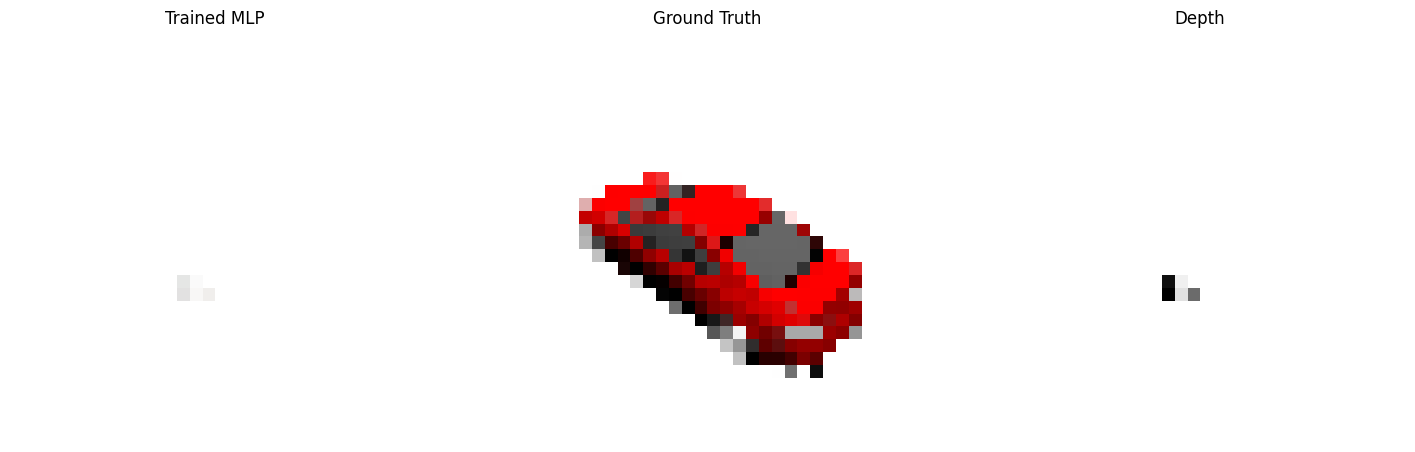

Step 130: loss = 0.11168


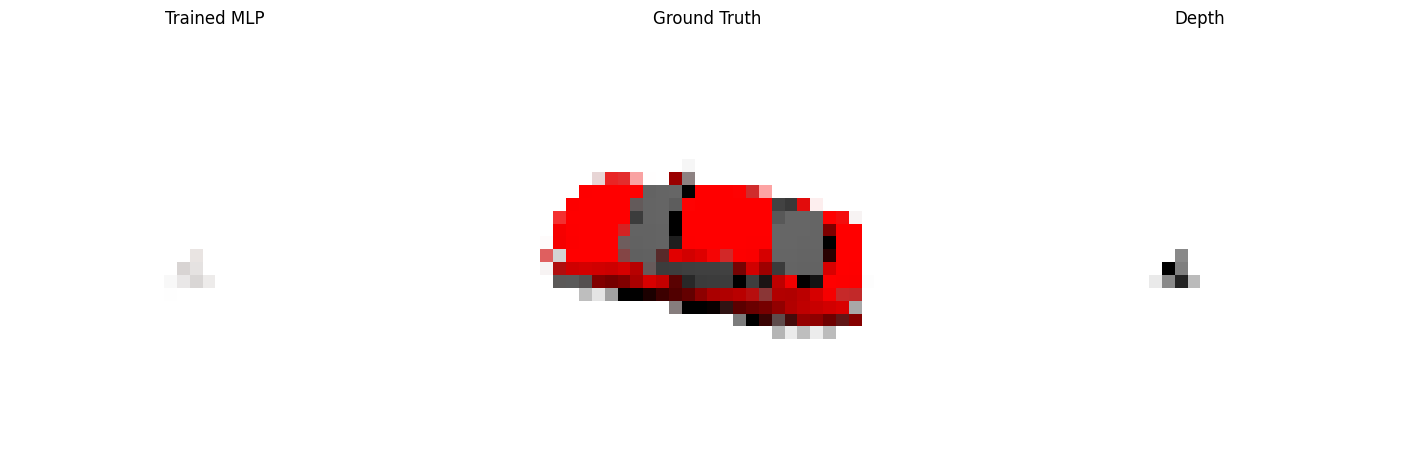

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 140: loss = 0.11086


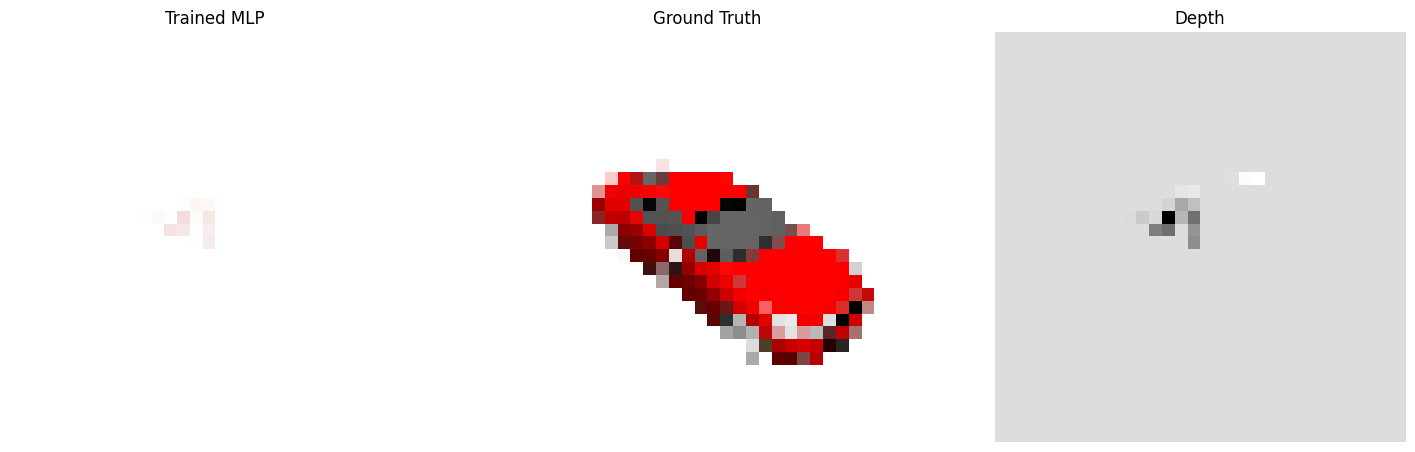

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 150: loss = 0.13440
same view dir as src


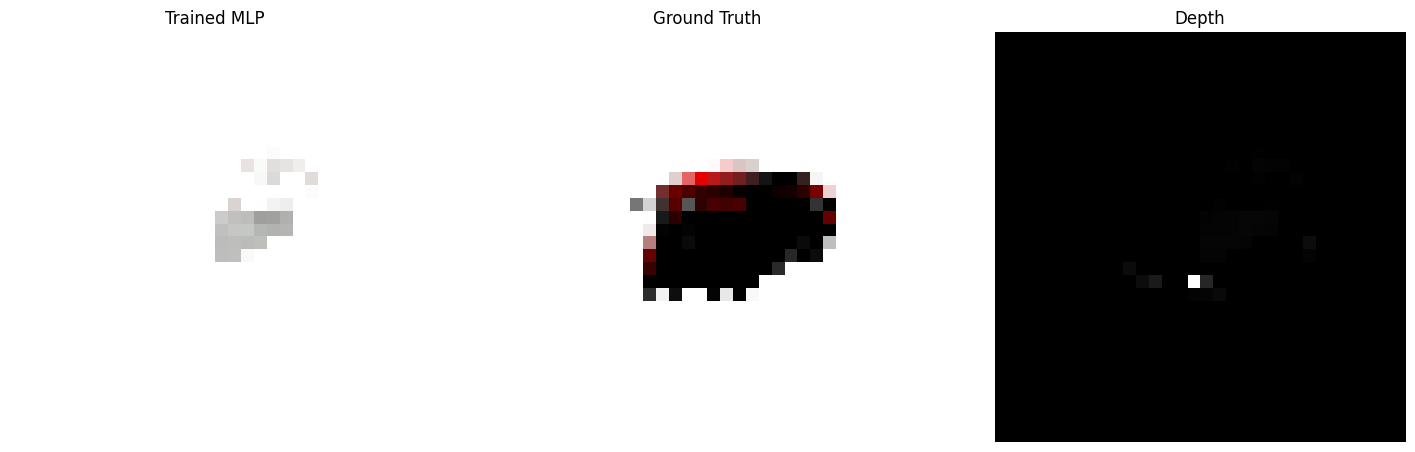

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 160: loss = 1200268315863754246979584.00000
same view dir as src


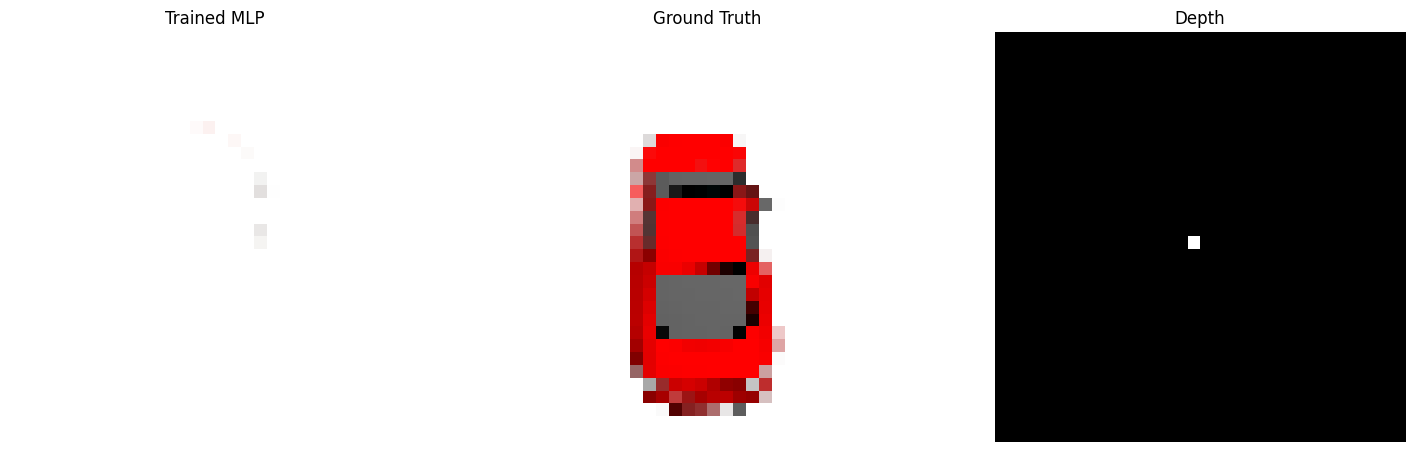

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 170: loss = 187.88153
same view dir as src


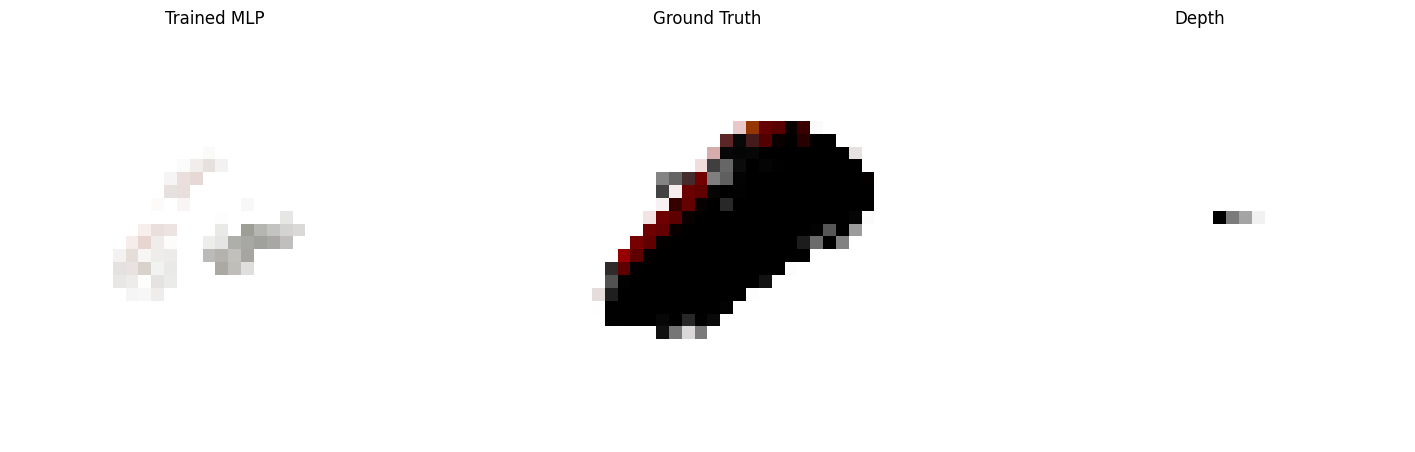

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 180: loss = 5.42649
same view dir as src


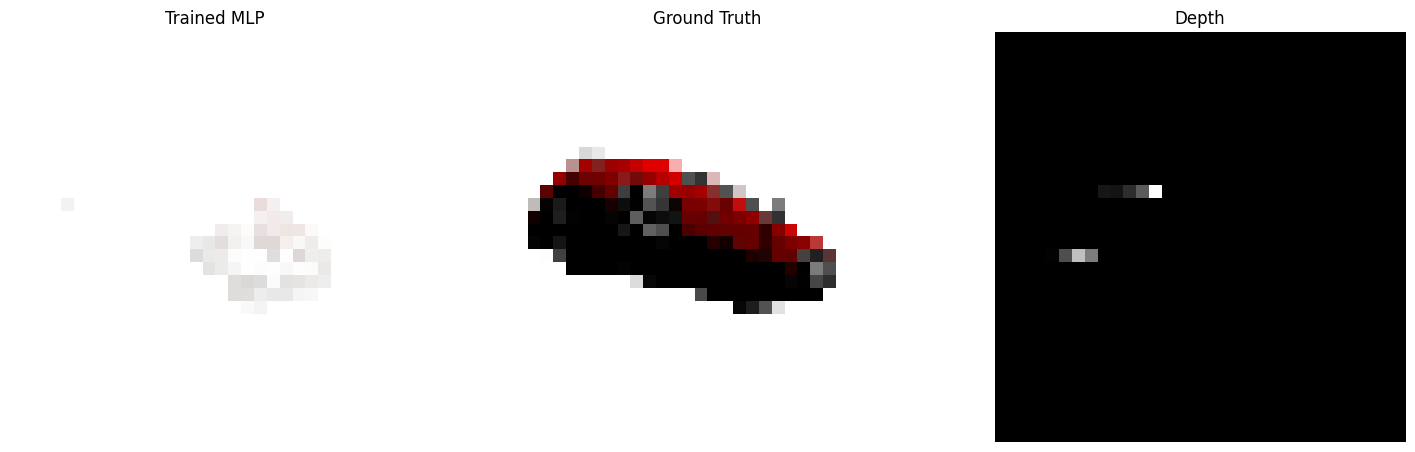

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 190: loss = 15523614055670413787136.00000
same view dir as src


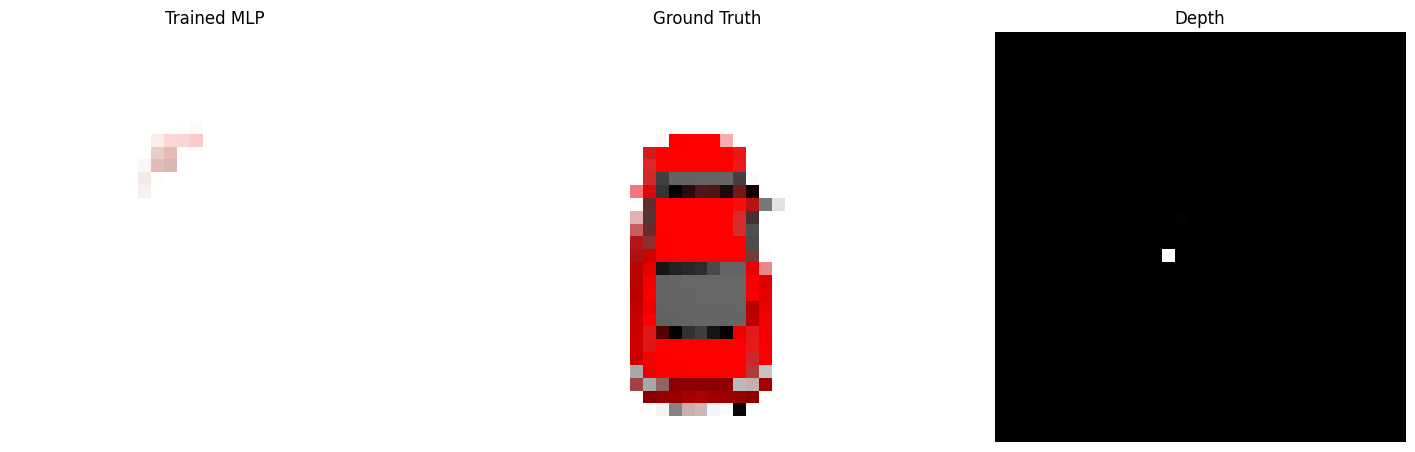

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 200: loss = 63706.16797
same view dir as src


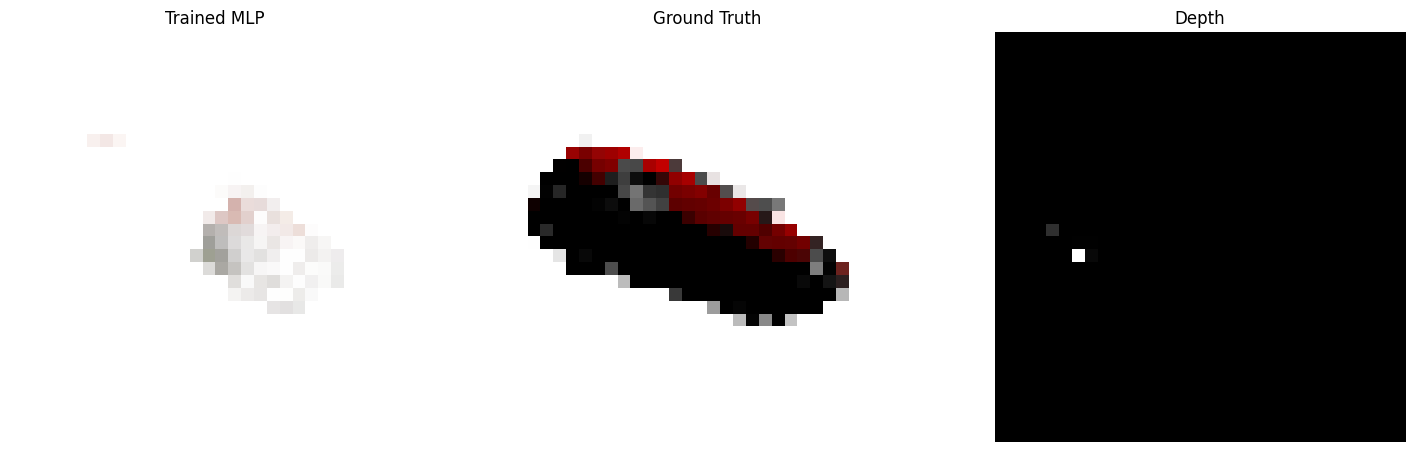

In [8]:
# Create a custom conf
from pyhocon import ConfigFactory
conf = ConfigFactory.parse_file(f"adaptive-volume-rendering/conf/default_mv.conf")

# Create a pixelnerf net
net = make_new_model(conf["model"]).to(device=device)
net.stop_encoder_grad = True

# Load pretrianed weights
model_path = f"{root_dir}checkpoints/srn_car/pixel_nerf_latest"
net.load_weights(model_path)

# Combine with volumerenderer
renderer = AdaptiveVolumeRenderer.from_conf(conf["adaptive_renderer"]).to(
    device=device
)

rf_and_renderer = RadFieldAndRenderer(net, renderer).to(device=device)

######## TODO
# Test dataset
sl = 32
train_dataset = SceneClassDataset(root_dir=f"{root_dir}data/cars_train",
                                             max_num_instances=1,
                                             max_observations_per_instance=50,
                                             img_sidelength=sl,
                                             specific_observation_idcs=None,
                                             samples_per_instance=2)


train_dataloader = DataLoader(train_dataset,
                                      batch_size=1,
                                      shuffle=True,
                                      drop_last=True,
                                      collate_fn=train_dataset.collate_fn
                                      )

# Configurations
optim = torch.optim.Adam(lr=5e-5, params=rf_and_renderer.parameters())

try:
    _ = fit(net,
        rf_and_renderer, 
        train_dataloader, 
        loss_fn=mse_loss, 
        resolution=(sl, sl, 3), 
        plotting_function=plot_output_ground_truth, 
        optimizer=optim, 
        total_steps=500,
        steps_til_summary=10
        )
except Exception:
    print(traceback.format_exc())
